**MALARIA PARASITE DETECTION USING DEEP LEARNING APPROACH**

This project investigates the effectiveness of various Convolutional Neural Network (CNN) architectures for predicting malaria from microscopic blood smear images.

The aim is to develop a  MINIMAL model that can accurately classify images as either 'Infected' or 'Uninfected' with malaria parasites.

In [ ]:
pip install tensorflow

**IMPORT LIBRARIES**

In [ ]:
# Import necessary libraries
import numpy as np # NumPy for numerical computing.
import pandas as pd
import matplotlib.pyplot as plt # Matplotlib for plotting(displaying images and graphs).
import seaborn as sns

import tensorflow as tf # TensorFlow library for machine learning and neural network models.
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout # Importing components from Keras for building and training models.
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

**IMPORT DATASET**

In [ ]:
# Load dataset using tensorflow
(ds_train, ds_test), ds_info = tfds.load(
    "malaria",
    split=["train[:70%]", "train[70%:]"],  # Splitting the dataset into training and test
    shuffle_files=True,
    as_supervised=False, # Returns dictionary (img, label)
    with_info=True # Load additional dataset information, including metadata
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.YIQDQT_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


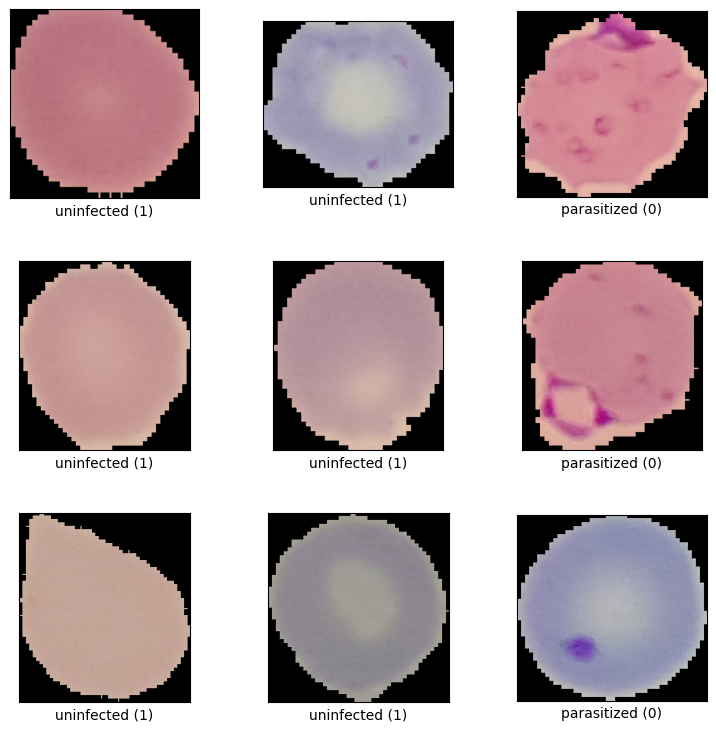

In [ ]:
# Print train dataset
data = tfds.show_examples(ds_train, ds_info, rows=3, cols=3)

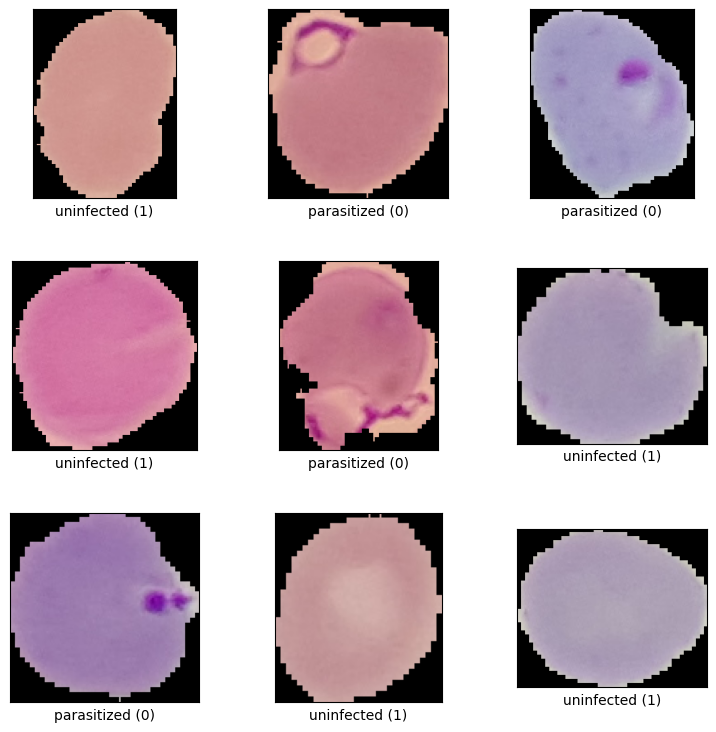

In [ ]:
# # Print test dataset
data = tfds.show_examples(ds_test, ds_info, rows=3, cols=3)

EXPLORATORY DATA ANALYSIS (EDA)


In [ ]:
# Load dataset using tensorflow
(ds_train, ds_test), ds_info = tfds.load(
    "malaria",
    split=["train[:70%]", "train[70%:]"],  # Splitting the dataset into training and test
    shuffle_files=True,
    as_supervised=True, # Returns tuple (img, label)
    with_info=True # Load additional dataset information, including metadata
)

# Show metadata/information about the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [ ]:
# Check the shape of a batch from the training dataset
for image, label in ds_train.take(1):
    print(image.shape)
    print(label.shape)

(103, 103, 3)
()


In [ ]:
# Check the shape of a batch from the training dataset
for image, label in ds_test.take(1):
    print(image.shape)
    print(label.shape)

(151, 115, 3)
()


In [ ]:
# Check length of training dataset
len(ds_train)

19291

In [ ]:
# Check length of test dataset
len(ds_test)

8267

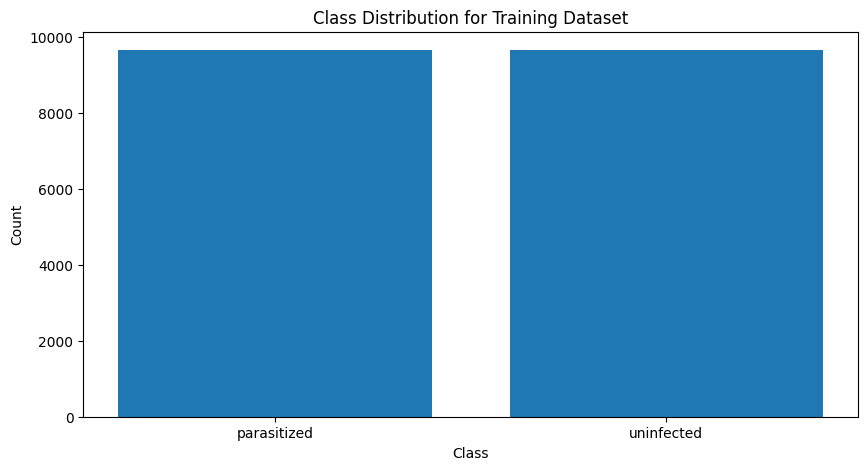

In [ ]:
# Plot class distribution for the training set
labels_train = []
for image, label in ds_train:
    labels_train.append(label.numpy())
labels_train = np.array(labels_train)
class_counts_train = np.bincount(labels_train)
plt.figure(figsize=(10, 5))
plt.bar(ds_info.features['label'].names, class_counts_train)
plt.title("Class Distribution for Training Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

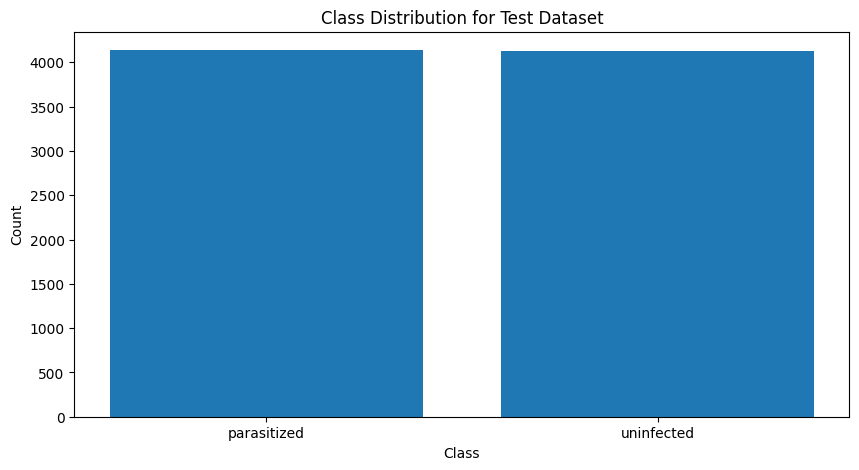

In [ ]:
# Plot class distribution for the test set
labels_test = []
for image, label in ds_test:
    labels_test.append(label.numpy())
labels_test = np.array(labels_test)
class_counts_test = np.bincount(labels_test)
plt.figure(figsize=(10, 5))
plt.bar(ds_info.features['label'].names, class_counts_test)
plt.title("Class Distribution for Test Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

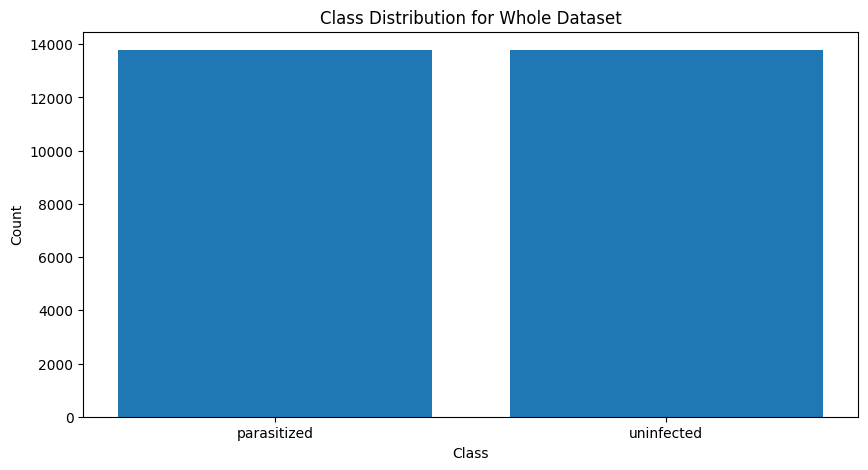

In [ ]:
# Plot class distribution for the whole dataset
labels_all = np.concatenate([labels_train, labels_test])
class_counts_all = np.bincount(labels_all)
plt.figure(figsize=(10, 5))
plt.bar(ds_info.features['label'].names, class_counts_all)
plt.title("Class Distribution for Whole Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**DATA PRE-PROCESSING**

In [ ]:
def img_process(image, label):
  """
  define a function that takes in the image and label as inputs,
  converts the data type of the image, resize the image pixel and
  returns the image and labels
  """
  image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32
  image = tf.image.resize(image, [150, 150])  # Resize  the image

  return image, label

In [ ]:
# Apply preprocessing to the datasets
# Training dataset
ds_train = ds_train.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
ds_test = ds_test.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(64)
ds_test = ds_test.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Check the shape of a batch from the training dataset
for image, label in ds_train.take(1):
    print(image.shape)
    print(label.shape)

(64, 150, 150, 3)
(64,)


In [ ]:
# Check the shape of a batch from the training dataset
for image, label in ds_test.take(1):
    print(image.shape)
    print(label.shape)

(64, 150, 150, 3)
(64,)


**CUSTOM MODEL DEFINITION**

Custom Model with One Convolutional Layer

In [ ]:
# Custom model 1

# Input Layer
input = layers.Input(shape=(150, 150, 3), dtype='float32', name='Input')

# First Convolutional layer
Conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input)
Pool1 = layers.MaxPool2D((2, 2), name='Pool1')(Conv1)

Drop1 = layers.Dropout((0.2), name='Drop1')(Pool1)

# Flatten layer
Flatten1 = layers.Flatten(name='Flatten1')(Drop1)

# Fully connected layers
Dense1 = layers.Dense(128, activation='relu', name='Dense1')(Flatten1)
Drop2 = layers.Dropout(0.5, name='Drop2')(Dense1)

# Output layer
output = layers.Dense(1, activation='sigmoid', name='Output')(Drop2)

# Create the model
model = keras.Model(inputs=input, outputs=output)

In [ ]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 Drop1 (Dropout)             (None, 75, 75, 32)        0         
                                                                 
 Flatten1 (Flatten)          (None, 180000)            0         
                                                                 
 Dense1 (Dense)              (None, 128)               23040128  
                                                                 
 Drop2 (Dropout)             (None, 128)               0     

In [ ]:
# Compile the model
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=[Precision(), Recall()]
              )

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best val_loss
    )

In [ ]:
# Train the model
history = model.fit(ds_train,
    epochs=20,
    validation_data=ds_test,
    callbacks=[early_stopping]
                    )

Epoch 1/20
302/302 [==============================] - 19s 46ms/step - loss: 0.8760 - accuracy: 0.6905 - precision: 0.6871 - recall: 0.7001 - val_loss: 0.4766 - val_accuracy: 0.7870 - val_precision: 0.7396 - val_recall: 0.8852
Epoch 2/20
302/302 [==============================] - 12s 40ms/step - loss: 0.4112 - accuracy: 0.8365 - precision: 0.8493 - recall: 0.8183 - val_loss: 0.3431 - val_accuracy: 0.8569 - val_precision: 0.8357 - val_recall: 0.8881
Epoch 3/20
302/302 [==============================] - 12s 40ms/step - loss: 0.3083 - accuracy: 0.8866 - precision: 0.8981 - recall: 0.8723 - val_loss: 0.2928 - val_accuracy: 0.9023 - val_precision: 0.9263 - val_recall: 0.8738
Epoch 4/20
302/302 [==============================] - 12s 40ms/step - loss: 0.2406 - accuracy: 0.9124 - precision: 0.9262 - recall: 0.8964 - val_loss: 0.2754 - val_accuracy: 0.9056 - val_precision: 0.8765 - val_recall: 0.9441
Epoch 5/20
302/302 [==============================] - 12s 40ms/step - loss: 0.1933 - accuracy: 0

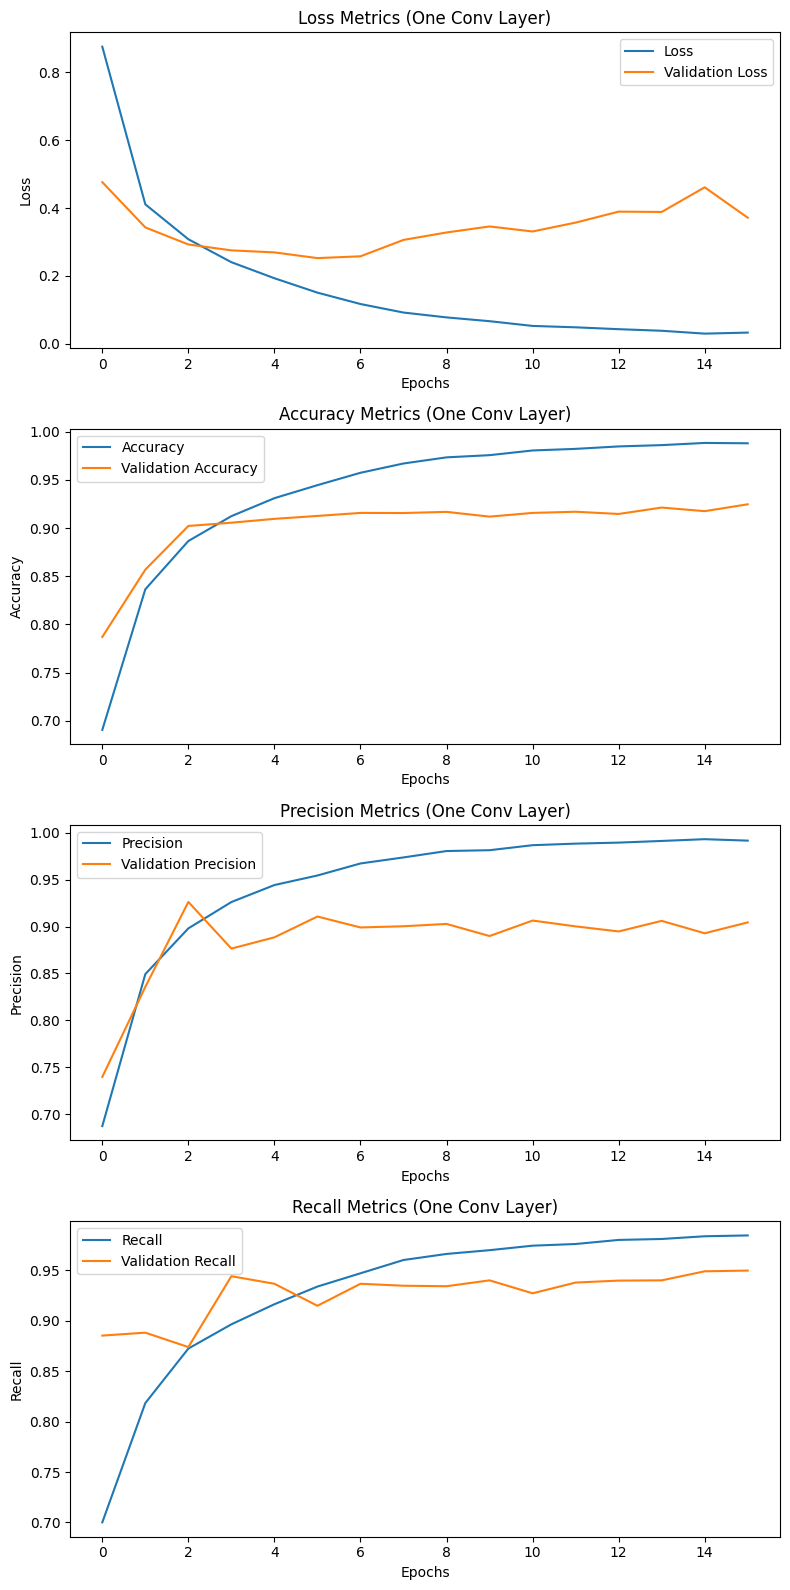

In [ ]:
# Create a figure and axis object with subplots
fig, ax = plt.subplots(4, figsize=(8, 16))

# Plotting Loss Metrics
ax[0].plot(history.history['loss'], label='Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Metrics (One Conv Layer)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting Accuracy Metrics
ax[1].plot(history.history['accuracy'], label='Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy Metrics (One Conv Layer)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Plotting Precision Metrics
ax[2].plot(history.history['precision'], label='Precision')
ax[2].plot(history.history['val_precision'], label='Validation Precision')
ax[2].set_title('Precision Metrics (One Conv Layer)')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Precision')
ax[2].legend()

# Plotting Recall Metrics
ax[3].plot(history.history['recall'], label='Recall')
ax[3].plot(history.history['val_recall'], label='Validation Recall')
ax[3].set_title('Recall Metrics (One Conv Layer)')
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Recall')
ax[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test dataset
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = model.predict(ds_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

# Classification report
class_report = classification_report(y_true, y_pred,
                                     target_names=ds_info.features['label'].names)

# Print classification report
print(class_report)

130/130 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

 parasitized       0.91      0.91      0.91      4138
  uninfected       0.91      0.91      0.91      4129

    accuracy                           0.91      8267
   macro avg       0.91      0.91      0.91      8267
weighted avg       0.91      0.91      0.91      8267



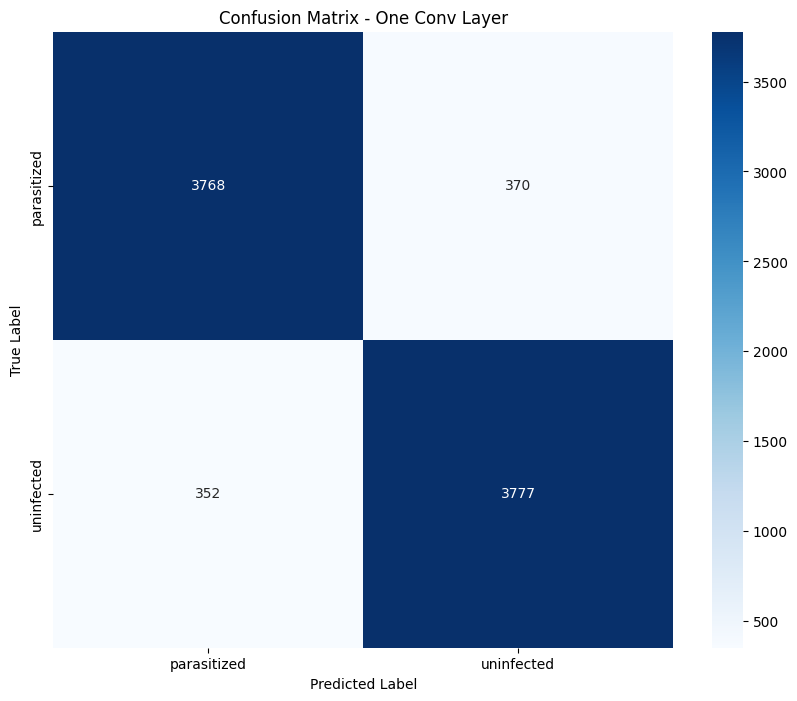

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',\
            xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - One Conv Layer')
plt.show()

Custom Model with Two Convolutional Layers

In [ ]:
# Custom Model 2

# Input Layer
input = layers.Input(shape=(150, 150, 3), dtype='float32', name='Input')

# First Convolutional layer
Conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input)
Pool1 = layers.MaxPool2D((2, 2), name='Pool1')(Conv1)

# Second Convolutional Layer
Conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(Pool1)
Pool2 = layers.MaxPool2D((2, 2), name='Pool2')(Conv2)

Drop1 = layers.Dropout((0.2), name='Drop1')(Pool2)

# Flatten layer
Flatten1 = layers.Flatten(name='Flatten1')(Drop1)

# Fully connected layers
Dense1 = layers.Dense(128, activation='relu', name='Dense1')(Flatten1)
Drop2 = layers.Dropout(0.5, name='Drop2')(Dense1)

# Output layer
output = layers.Dense(1, activation='sigmoid', name='Output')(Drop2)

# Create the model
model2 = keras.Model(inputs=input, outputs=output)

In [ ]:
# Print model summary
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 37, 37, 64)        0         
                                                                 
 Drop1 (Dropout)             (None, 37, 37, 64)        0         
                                                                 
 Flatten1 (Flatten)          (None, 87616)             0   

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              weighted_metrics=[Precision(), Recall()]
                )

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best val_loss
    )

In [ ]:
# Train the model
history = model2.fit(ds_train,
                    epochs=20,
                    validation_data=ds_test,
                    callbacks=[early_stopping]
                      )

Epoch 1/20
302/302 [==============================] - 21s 60ms/step - loss: 0.5168 - accuracy: 0.7503 - precision_1: 0.7463 - recall_1: 0.7588 - val_loss: 0.2519 - val_accuracy: 0.9109 - val_precision_1: 0.9159 - val_recall_1: 0.9046
Epoch 2/20
302/302 [==============================] - 17s 57ms/step - loss: 0.2389 - accuracy: 0.9147 - precision_1: 0.9239 - recall_1: 0.9039 - val_loss: 0.1965 - val_accuracy: 0.9229 - val_precision_1: 0.9398 - val_recall_1: 0.9036
Epoch 3/20
302/302 [==============================] - 17s 57ms/step - loss: 0.1846 - accuracy: 0.9287 - precision_1: 0.9429 - recall_1: 0.9126 - val_loss: 0.1939 - val_accuracy: 0.9344 - val_precision_1: 0.9308 - val_recall_1: 0.9385
Epoch 4/20
302/302 [==============================] - 17s 56ms/step - loss: 0.1509 - accuracy: 0.9415 - precision_1: 0.9568 - recall_1: 0.9249 - val_loss: 0.1927 - val_accuracy: 0.9336 - val_precision_1: 0.9464 - val_recall_1: 0.9191
Epoch 5/20
302/302 [==============================] - 17s 55ms/s

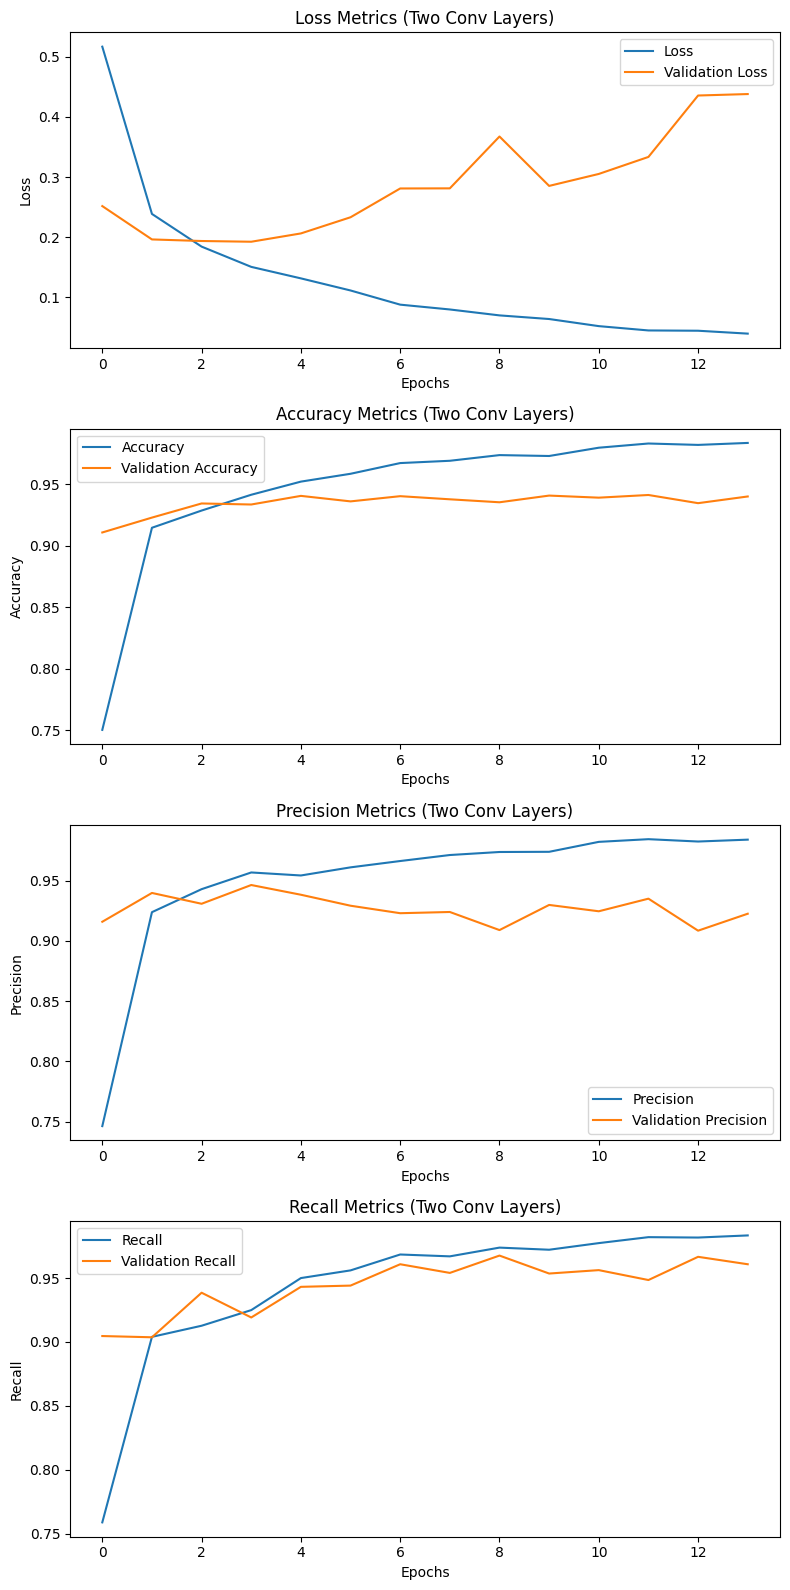

In [ ]:
# Create a figure and axis object with subplots
fig, ax = plt.subplots(4, figsize=(8, 16))

# Plotting Loss Metrics
ax[0].plot(history.history['loss'], label='Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Metrics (Two Conv Layers)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting Accuracy Metrics
ax[1].plot(history.history['accuracy'], label='Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy Metrics (Two Conv Layers)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Plotting Precision Metrics
ax[2].plot(history.history['precision_1'], label='Precision')
ax[2].plot(history.history['val_precision_1'], label='Validation Precision')
ax[2].set_title('Precision Metrics (Two Conv Layers)')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Precision')
ax[2].legend()

# Plotting Recall Metrics
ax[3].plot(history.history['recall_1'], label='Recall')
ax[3].plot(history.history['val_recall_1'], label='Validation Recall')
ax[3].set_title('Recall Metrics (Two Conv Layers)')
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Recall')
ax[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test dataset
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = model2.predict(ds_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

# Classification report
class_report = classification_report(y_true, y_pred,
                                     target_names=ds_info.features['label'].names)

# Print classification report
print(class_report)

130/130 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

 parasitized       0.92      0.95      0.93      4138
  uninfected       0.95      0.92      0.93      4129

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267



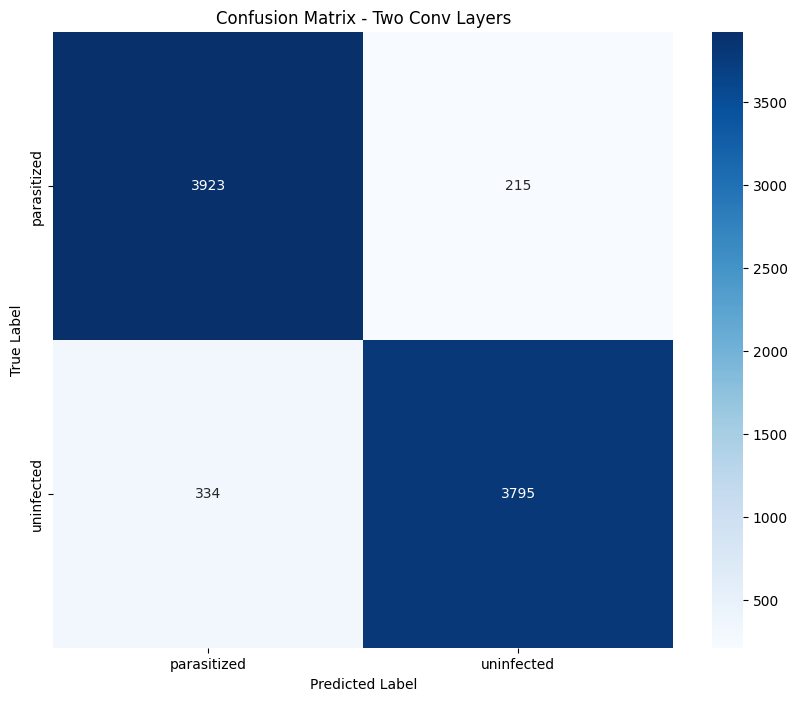

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',\
            xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Two Conv Layers')
plt.show()

Custom model with Three Convolutional Layers

In [ ]:
# Custom Model 3

# Input Layer
input = layers.Input(shape=(150, 150, 3), dtype='float32', name='Input')

# First Convolutional layer
Conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input)
Pool1 = layers.MaxPool2D((2, 2), name='Pool1')(Conv1)

# Second Convolutional Layer
Conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(Pool1)
Pool2 = layers.MaxPool2D((2, 2), name='Pool2')(Conv2)

# Third Convolutional Layer
Conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv3')(Pool2)
Pool3 = layers.MaxPool2D((2, 2), name='Pool3')(Conv3)

Drop1 = layers.Dropout((0.2), name='Drop1')(Pool3)

# Flatten layer
Flatten1 = layers.Flatten(name='Flatten1')(Drop1)

# Fully connected layers
Dense1 = layers.Dense(128, activation='relu', name='Dense1')(Flatten1)
Drop2 = layers.Dropout(0.5, name='Drop2')(Dense1)

# Output layer
output = layers.Dense(1, activation='sigmoid', name='Output')(Drop2)

# Create the model
model3 = keras.Model(inputs=input, outputs=output)

In [ ]:
# Print model summary
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 37, 37, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 37, 37, 128)       73856     
                                                                 
 Pool3 (MaxPooling2D)        (None, 18, 18, 128)       0   

In [ ]:
# Compile the model
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              weighted_metrics=[Precision(), Recall()]
                )

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best val_loss
    )

In [ ]:
# Train the model
history = model3.fit(ds_train,
                    epochs=20,
                    validation_data=ds_test,
                    callbacks = [early_stopping]
                      )

Epoch 1/20
302/302 [==============================] - 23s 69ms/step - loss: 0.4149 - accuracy: 0.8028 - precision_2: 0.7965 - recall_2: 0.8138 - val_loss: 0.1867 - val_accuracy: 0.9283 - val_precision_2: 0.9363 - val_recall_2: 0.9189
Epoch 2/20
302/302 [==============================] - 20s 68ms/step - loss: 0.1925 - accuracy: 0.9325 - precision_2: 0.9431 - recall_2: 0.9206 - val_loss: 0.1798 - val_accuracy: 0.9417 - val_precision_2: 0.9230 - val_recall_2: 0.9637
Epoch 3/20
302/302 [==============================] - 20s 68ms/step - loss: 0.1659 - accuracy: 0.9403 - precision_2: 0.9427 - recall_2: 0.9377 - val_loss: 0.1576 - val_accuracy: 0.9468 - val_precision_2: 0.9489 - val_recall_2: 0.9443
Epoch 4/20
302/302 [==============================] - 20s 67ms/step - loss: 0.1445 - accuracy: 0.9522 - precision_2: 0.9491 - recall_2: 0.9558 - val_loss: 0.1586 - val_accuracy: 0.9499 - val_precision_2: 0.9242 - val_recall_2: 0.9801
Epoch 5/20
302/302 [==============================] - 20s 67ms/s

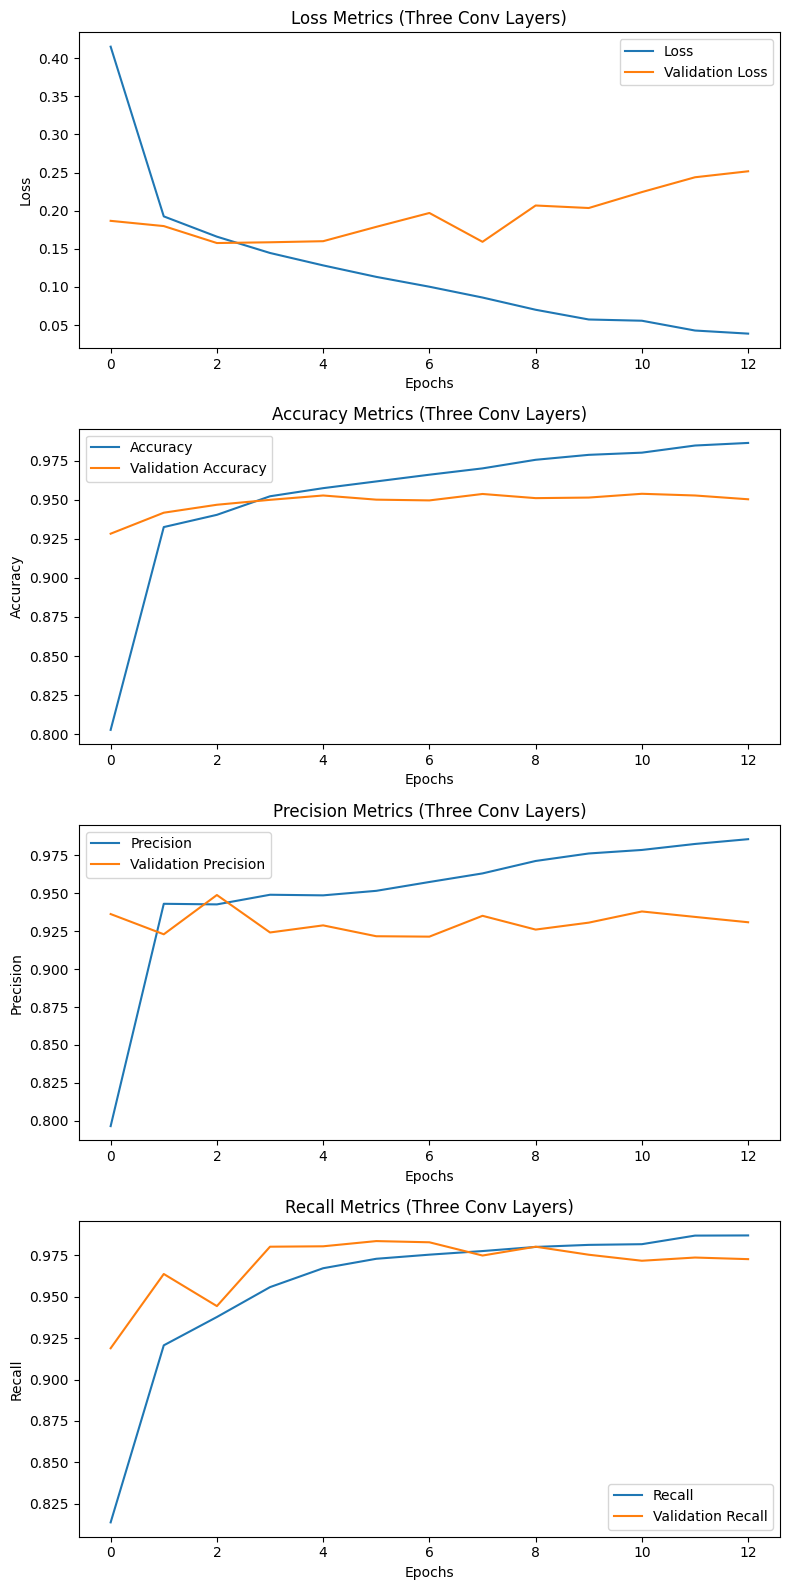

In [ ]:
# Create a figure and axis object with subplots
fig, ax = plt.subplots(4, figsize=(8, 16))

# Plotting Loss Metrics
ax[0].plot(history.history['loss'], label='Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Metrics (Three Conv Layers)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting Accuracy Metrics
ax[1].plot(history.history['accuracy'], label='Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy Metrics (Three Conv Layers)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Plotting Precision Metrics
ax[2].plot(history.history['precision_2'], label='Precision')
ax[2].plot(history.history['val_precision_2'], label='Validation Precision')
ax[2].set_title('Precision Metrics (Three Conv Layers)')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Precision')
ax[2].legend()

# Plotting Recall Metrics
ax[3].plot(history.history['recall_2'], label='Recall')
ax[3].plot(history.history['val_recall_2'], label='Validation Recall')
ax[3].set_title('Recall Metrics (Three Conv Layers)')
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Recall')
ax[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test dataset
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = model3.predict(ds_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

# Classification report
class_report = classification_report(y_true, y_pred,
                                     target_names=ds_info.features['label'].names)

# Print classification report
print(class_report)

130/130 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

 parasitized       0.94      0.95      0.95      4138
  uninfected       0.95      0.94      0.95      4129

    accuracy                           0.95      8267
   macro avg       0.95      0.95      0.95      8267
weighted avg       0.95      0.95      0.95      8267



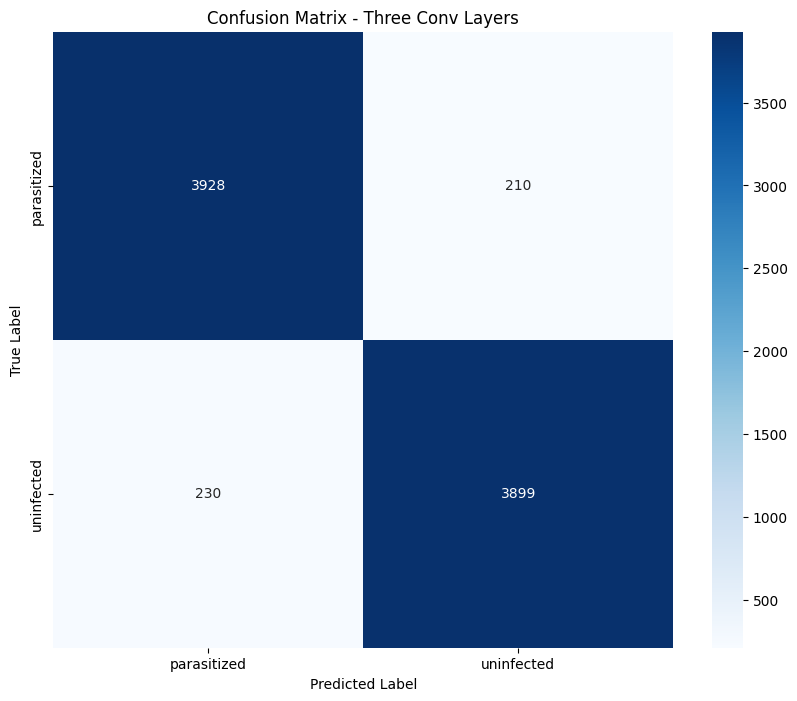

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',\
            xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Three Conv Layers')
plt.show()

Custom Model with Four Convolutional Layers

In [ ]:
# Custom Model 4

# Input Layer
input = layers.Input(shape=(150, 150, 3), dtype='float32', name='Input')

# First Convolutional layer
Conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input)
Pool1 = layers.MaxPool2D((2, 2), name='Pool1')(Conv1)

# Second Convolutional Layer
Conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(Pool1)
Pool2 = layers.MaxPool2D((2, 2), name='Pool2')(Conv2)

# Third Convolutional Layer
Conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv3')(Pool2)
Pool3 = layers.MaxPool2D((2, 2), name='Pool3')(Conv3)

# Fourth Convolutional Layer
Conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv4')(Pool3)
Pool4 = layers.MaxPool2D((2, 2), name='Pool4')(Conv4)

Drop1 = layers.Dropout((0.2), name='Drop1')(Pool4)

# Flatten layer
Flatten1 = layers.Flatten(name='Flatten1')(Drop1)

# Fully connected layers
Dense1 = layers.Dense(128, activation='relu', name='Dense1')(Flatten1)
Drop2 = layers.Dropout(0.5, name='Drop2')(Dense1)

# Output layer
output = layers.Dense(1, activation='sigmoid', name='Output')(Drop2)

# Create the model
model4 = keras.Model(inputs=input, outputs=output)

In [ ]:
# Print model summary
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 37, 37, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 37, 37, 128)       73856     
                                                                 
 Pool3 (MaxPooling2D)        (None, 18, 18, 128)       0   

In [ ]:
# Compile the model
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              weighted_metrics=[Precision(), Recall()]
                )

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best val_loss
    )

In [ ]:
# Train the model
history = model4.fit(ds_train,
                    epochs=20,
                    validation_data=ds_test,
                    callbacks = [early_stopping]
                      )

Epoch 1/20
302/302 [==============================] - 26s 77ms/step - loss: 0.4858 - accuracy: 0.7514 - precision_3: 0.7397 - recall_3: 0.7762 - val_loss: 0.1785 - val_accuracy: 0.9451 - val_precision_3: 0.9185 - val_recall_3: 0.9767
Epoch 2/20
302/302 [==============================] - 23s 75ms/step - loss: 0.1559 - accuracy: 0.9519 - precision_3: 0.9375 - recall_3: 0.9684 - val_loss: 0.1402 - val_accuracy: 0.9551 - val_precision_3: 0.9378 - val_recall_3: 0.9748
Epoch 3/20
302/302 [==============================] - 23s 75ms/step - loss: 0.1337 - accuracy: 0.9576 - precision_3: 0.9453 - recall_3: 0.9715 - val_loss: 0.1331 - val_accuracy: 0.9562 - val_precision_3: 0.9385 - val_recall_3: 0.9763
Epoch 4/20
302/302 [==============================] - 22s 74ms/step - loss: 0.1240 - accuracy: 0.9588 - precision_3: 0.9484 - recall_3: 0.9705 - val_loss: 0.1455 - val_accuracy: 0.9523 - val_precision_3: 0.9224 - val_recall_3: 0.9876
Epoch 5/20
302/302 [==============================] - 22s 74ms/s

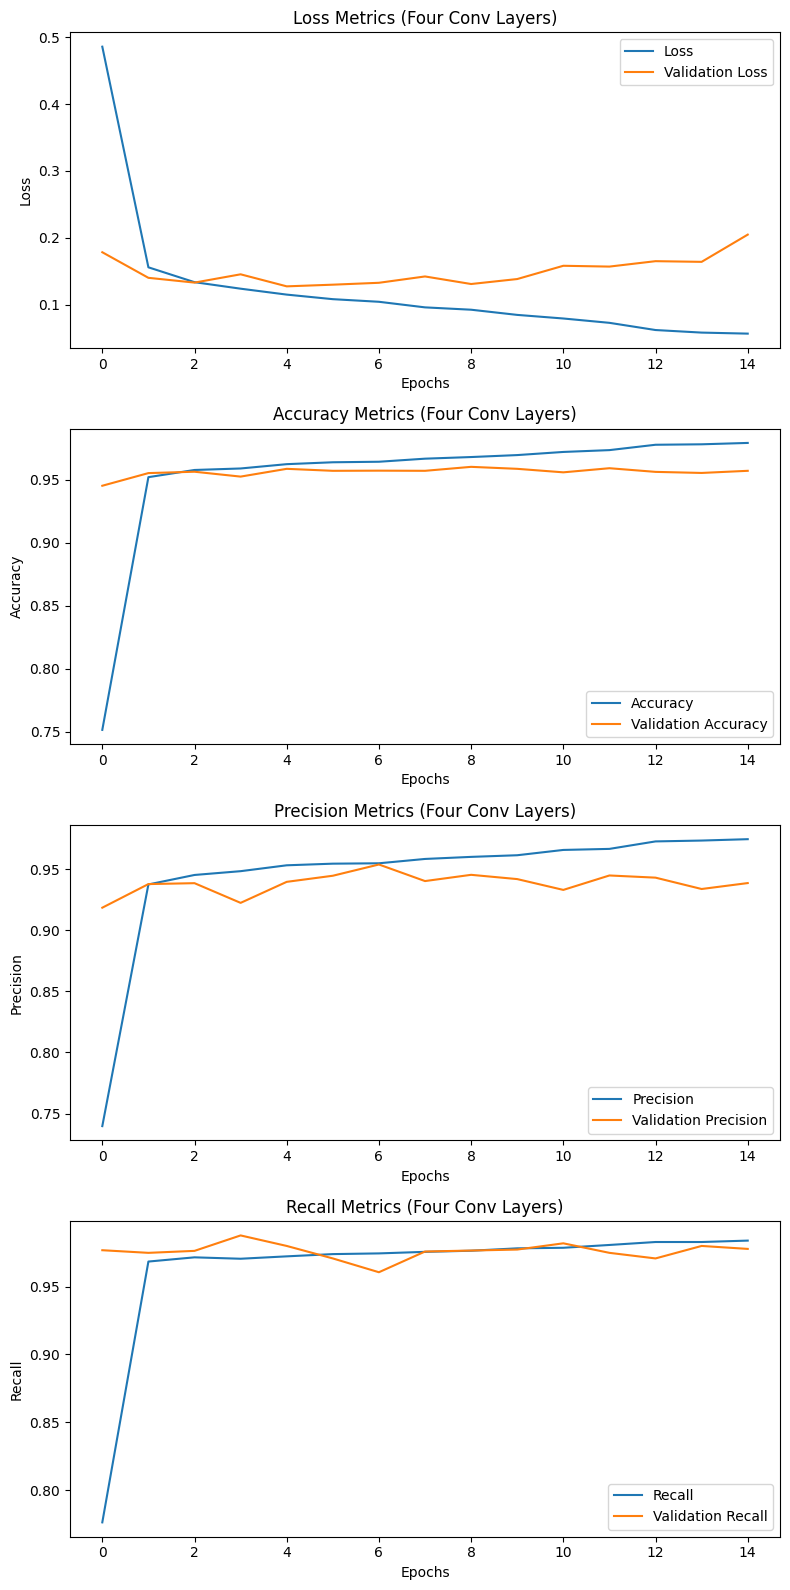

In [ ]:
# Create a figure and axis object with subplots
fig, ax = plt.subplots(4, figsize=(8, 16))

# Plotting Loss Metrics
ax[0].plot(history.history['loss'], label='Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Metrics (Four Conv Layers)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting Accuracy Metrics
ax[1].plot(history.history['accuracy'], label='Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy Metrics (Four Conv Layers)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Plotting Precision Metrics
ax[2].plot(history.history['precision_3'], label='Precision')
ax[2].plot(history.history['val_precision_3'], label='Validation Precision')
ax[2].set_title('Precision Metrics (Four Conv Layers)')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Precision')
ax[2].legend()

# Plotting Recall Metrics
ax[3].plot(history.history['recall_3'], label='Recall')
ax[3].plot(history.history['val_recall_3'], label='Validation Recall')
ax[3].set_title('Recall Metrics (Four Conv Layers)')
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Recall')
ax[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test dataset
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = model4.predict(ds_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

# Classification report
class_report = classification_report(y_true, y_pred,
                                     target_names=ds_info.features['label'].names)

# Print classification report
print(class_report)

130/130 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

 parasitized       0.98      0.94      0.96      4138
  uninfected       0.94      0.98      0.96      4129

    accuracy                           0.96      8267
   macro avg       0.96      0.96      0.96      8267
weighted avg       0.96      0.96      0.96      8267



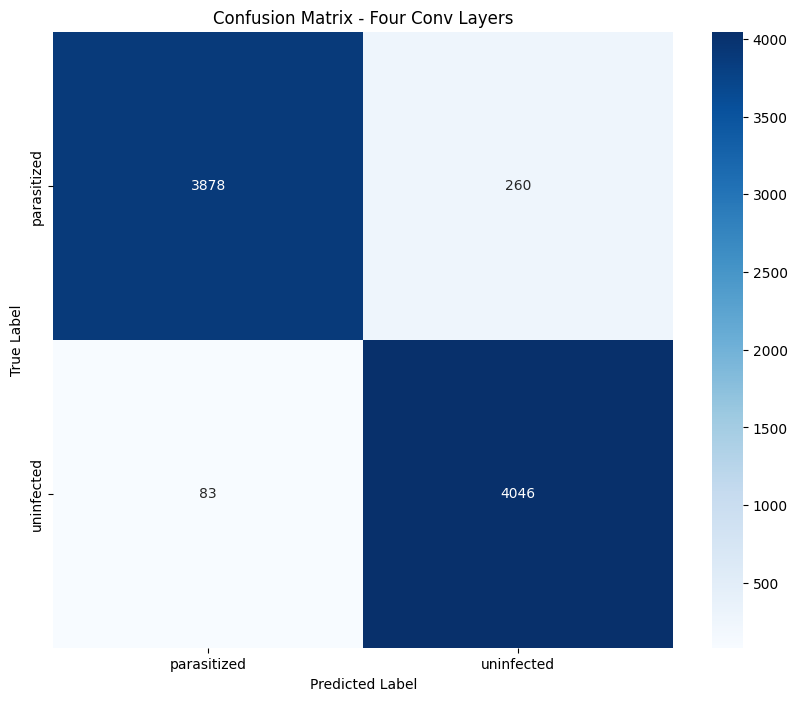

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',\
            xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Four Conv Layers')
plt.show()